In [46]:
from dask.distributed import Client

client = Client()
client.restart()  # Restart Dask cluster, clearing all tasks and memory

/env/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40481 instead
  warnings.warn(
2024-08-11 10:01:34,583 - distributed.nanny - WARNING - Restarting worker
2024-08-11 10:01:34,636 - distributed.nanny - WARNING - Restarting worker


In [47]:
client.shutdown()

In [48]:
import gc
gc.collect()

17148

In [49]:
import os
import datacube
import numpy as np
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
import matplotlib.pyplot as plt
import contextily as cx
from dea_tools.datahandling import load_ard
from dea_tools.bandindices import calculate_indices
from dea_tools.dask import create_local_dask_cluster

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [52]:
# Step 1: Load the Shapefile
shapefile_path = '/home/jovyan/Yunbenun/HorseshoeBay/Nelly.shp'
nelly_gdf = gpd.read_file(shapefile_path)

In [53]:
# Step 2: Transform CRS to WGS84 (EPSG:4326) for consistency
wgs84_epsg = 4326
nelly_gdf = nelly_gdf.to_crs(epsg=wgs84_epsg)


In [54]:
# Step 3: Get the Bounding Box of the Area
bounding_box_df = nelly_gdf.bounds

# Extract the values from the DataFrame.
nelly_lat_min = bounding_box_df['miny'].min()
nelly_lat_max = bounding_box_df['maxy'].max()
nelly_lon_min = bounding_box_df['minx'].min()
nelly_lon_max = bounding_box_df['maxx'].max()

# Print the bounding box coordinates.
print("Latitude Min:", nelly_lat_min)
print("Latitude Max:", nelly_lat_max)
print("Longitude Min:", nelly_lon_min)
print("Longitude Max:", nelly_lon_max)

Latitude Min: -19.158033220414392
Latitude Max: -19.157311191414404
Longitude Min: 146.8508185930001
Longitude Max: 146.85196815900008


/env/lib/python3.10/site-packages/contextily/tile.py:623: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


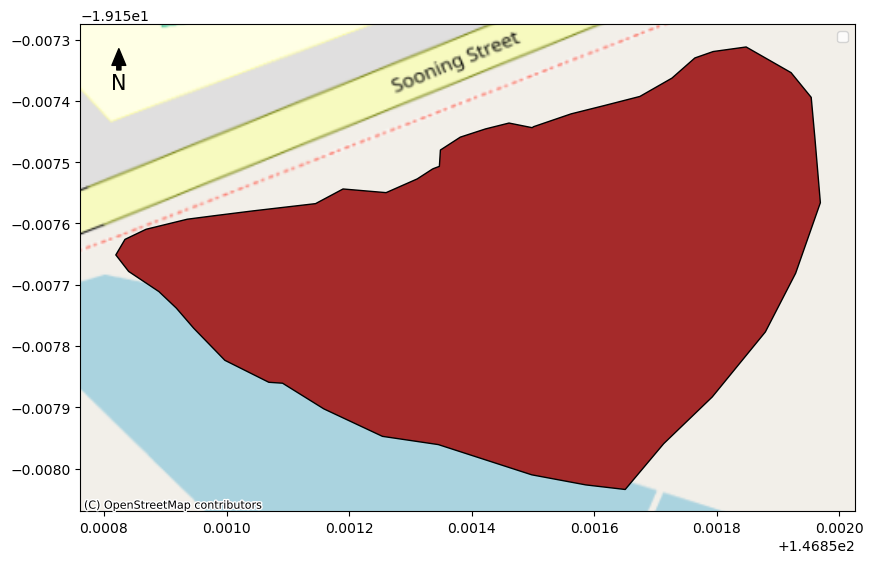

In [55]:
# Step 4: Display the Area of Interest on a Map
fig, ax = plt.subplots(figsize=(10, 10))
nelly_gdf.plot(ax=ax, color='brown', edgecolor='black', legend=True)

# Add a north arrow
x, y, arrow_length = 0.05, 0.95, 0.07
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=3, headwidth=10),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)

# Add OpenStreetMap basemap
cx.add_basemap(ax, crs=nelly_gdf.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

# Add legend
ax.legend()
plt.show()

In [56]:
# Step 5: Define Area of Interest
lat_min, lat_max = nelly_lat_min, nelly_lat_max
lon_min, lon_max = nelly_lon_min, nelly_lon_max

# Set the range of dates for the analysis
time_range = ('1988-10-08', '2024-10-08')  # Time range for Landsat data

In [57]:
# Step 6: Initialize Dask and Datacube
client = create_local_dask_cluster(return_client=True)
dc = datacube.Datacube(app='Vegetation_phenology')

/env/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34315 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jmackenzie@earthwatch.org.au/proxy/34315/status,
Dashboard: /user/jmackenzie@earthwatch.org.au/proxy/34315/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41259,Workers: 1
Dashboard: /user/jmackenzie@earthwatch.org.au/proxy/34315/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:38991,Total threads: 2
Dashboard: /user/jmackenzie@earthwatch.org.au/proxy/46129/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:38813,


2024-08-11 10:05:28,498 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'dataset-ce6b29583d4648b1a57315620ea00565' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x7efdbe5faf80>, (Dataset <id=ce6b2958-3d46-48b1-a573-15620ea00565 product=ga_ls7e_ard_3 location=s3://dea-public-data/baseline/ga_ls7e_ard_3/095/073/2011/10/02/ga_ls7e_ard_3-1-0_095073_2011-10-02_final.stac-item.json>,), {})
new run_spec: (<function execute_task at 0x7efdbe5faf80>, (Dataset <id=ce6b2958-3d46-48b1-a573-15620ea00565 product=ga_ls7e_ard_3 location=s3://dea-public-data/baseline/ga_ls7e_ard_3/095/07

In [58]:
# Step 7: Create a Query
query = {
    'x': (lon_min, lon_max),
    'y': (lat_min, lat_max),
    'time': time_range,
    'measurements': ['nbart_red', 'nbart_nir'],
    'resolution': (-30, 30),
    'output_crs': 'EPSG:32755',  # Adjust CRS to match Landsat data
    'group_by': 'solar_day'
}

# Step 8: Load Data for Landsat 5, 7, 8, and 9
ds = load_ard(
    dc=dc,
    products=['ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3', 'ga_ls9c_ard_3'],
    min_gooddata=0.99,
    **query,
)


Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3
    ga_ls8c_ard_3
    ga_ls9c_ard_3
Counting good quality pixels for each time step using fmask


/env/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 12.21 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Filtering to 1016 out of 2017 time steps with at least 99.0% good quality pixels
Applying fmask pixel quality/cloud mask
Loading 1016 time steps


In [36]:
# Step 9: Ensure CRS Alignment and Clip the Dataset
# Reproject the GeoDataFrame to match the CRS of the datacube query
nelly_gdf = nelly_gdf.to_crs(ds.geobox.crs)
ds_clipped = ds.rio.clip(nelly_gdf.geometry, all_touched=True, drop=False)

# Preview the clipped dataset
print(ds_clipped)

<xarray.Dataset> Size: 84kB
Dimensions:      (time: 1050, y: 3, x: 3)
Coordinates:
  * time         (time) datetime64[ns] 8kB 1988-10-09T23:47:24.499809 ... 202...
  * y            (y) float64 24B 7.883e+06 7.882e+06 7.882e+06
  * x            (x) float64 24B 4.856e+05 4.857e+05 4.857e+05
    spatial_ref  int64 8B 0
Data variables:
    nbart_red    (time, y, x) float32 38kB -999.0 1.032e+03 ... 1.179e+03 800.0
    nbart_nir    (time, y, x) float32 38kB -999.0 2.569e+03 ... 2.685e+03
Attributes:
    crs:           EPSG:32755
    grid_mapping:  spatial_ref


In [37]:
# Step 10: Perform NDVI Calculations
ds_clipped = calculate_indices(ds_clipped, index='NDVI', collection='ga_ls_3')

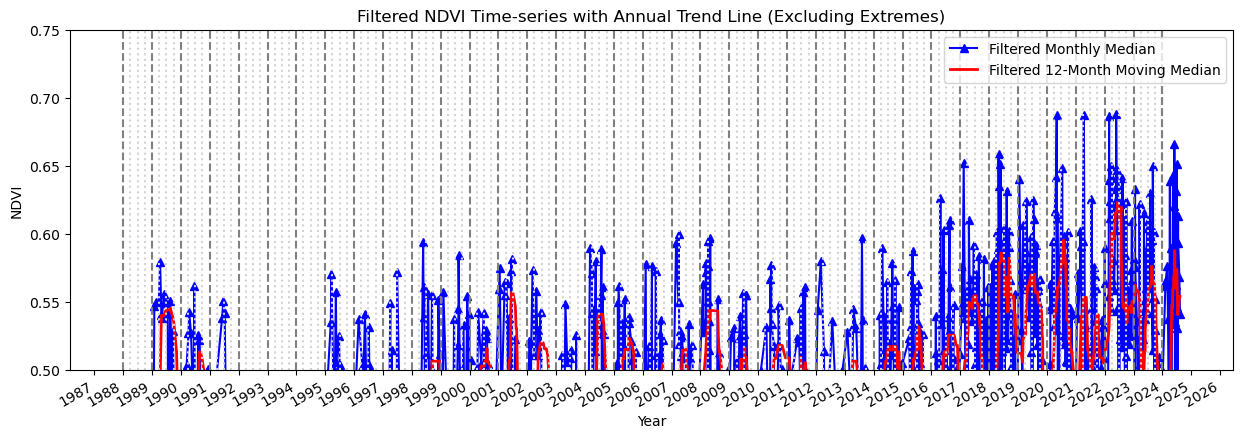

In [39]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Set the vegetation proxy (NDVI)
veg_proxy = 'NDVI'

# Set a threshold to exclude extreme values (adjust as needed)
threshold_percentile_low = 10
threshold_percentile_high = 90

# Calculate percentiles for filtering extreme values
percentile_low = ds_clipped[veg_proxy].quantile(q=threshold_percentile_low / 100, dim='time')
percentile_high = ds_clipped[veg_proxy].quantile(q=threshold_percentile_high / 100, dim='time')

# Filter out extreme values for monthly median
filtered_monthly = ds_clipped[veg_proxy].where(
    (ds_clipped[veg_proxy] >= percentile_low) & (ds_clipped[veg_proxy] <= percentile_high)
)

# Take the monthly median over 'x' and 'y' to reduce to 1D array
filtered_monthly_median = filtered_monthly.median(['x', 'y'])

# Plot the monthly median values along with the annual trend line
fig, ax = plt.subplots(figsize=(15, 5))

# Plotting the filtered monthly median
filtered_monthly_median.plot.line('b-^', ax=ax, label='Filtered Monthly Median')

# Calculate the 12-month moving median for the annual trend line
filtered_annual_trend = filtered_monthly_median.rolling(time=12, min_periods=1).median()
filtered_annual_trend.plot.line('r-', linewidth=2, ax=ax, label='Filtered 12-Month Moving Median')

# Set Y-axis limits explicitly
ax.set_ylim(0.5, 0.75)

# Draw vertical lines for each year
for year in range(1988, 2025):
    ax.vlines(np.datetime64(str(year) + '-01-01'), ymin=0.5, ymax=0.75, color='gray', linestyle='--')

# Set title, ylabel, and legend
ax.set_title(f'Filtered {veg_proxy} Time-series with Annual Trend Line (Excluding Extremes)')
ax.set_ylabel(veg_proxy)
ax.legend()

# Set x-axis label to 'Year'
ax.set_xlabel('Year')

# Add month intervals to the x-axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Customize the appearance of the minor (month) ticks
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.tick_params(axis='x', which='minor', size=0)  # Set size to 0 to hide minor tick marks

# Draw dashed line for the year 2024 major tick
ax.vlines(np.datetime64('2024-01-01'), ymin=0.5, ymax=0.75, color='gray', linestyle='--')

# Draw lighter grey dotted lines between major labels on months 5, 7, and 10
months_to_draw_dotted_lines = [4, 7, 10]
for year in range(1988, 2024):
    for month in months_to_draw_dotted_lines:
        ax.vlines(np.datetime64(f'{year}-{month:02d}-01'), ymin=0.5, ymax=0.75, color='lightgrey', linestyle=':')

# Autoformat the x-axis labels
fig.autofmt_xdate()

# Show the final plot
plt.show()


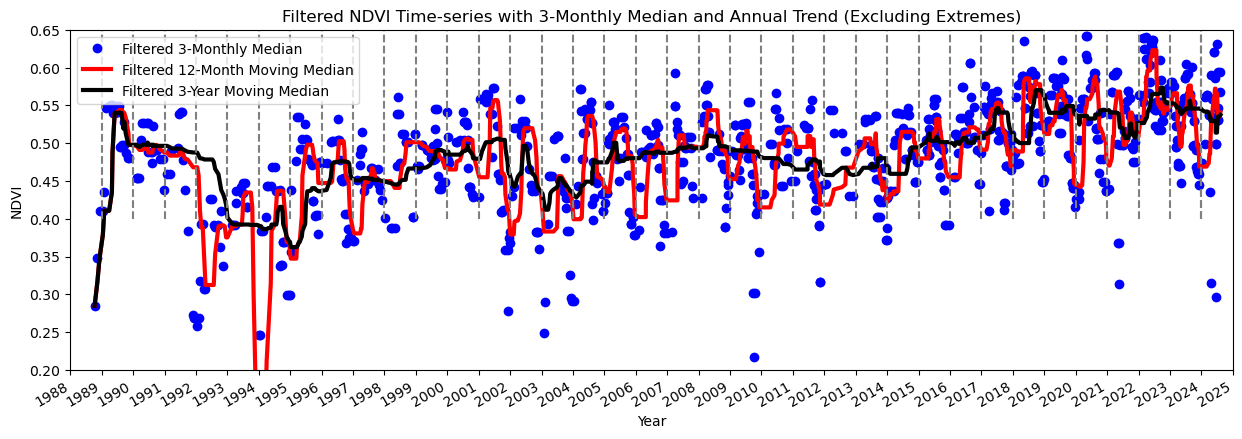

In [44]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Set the vegetation proxy (NDVI)
veg_proxy = 'NDVI'

# Set a threshold to exclude extreme values (adjust as needed)
threshold_percentile_low = 10
threshold_percentile_high = 90

# Calculate percentiles for filtering extreme values
percentile_low = ds_clipped[veg_proxy].quantile(q=threshold_percentile_low / 100, dim='time')
percentile_high = ds_clipped[veg_proxy].quantile(q=threshold_percentile_high / 100, dim='time')

# Filter out extreme values for 3-monthly median
filtered = ds_clipped[veg_proxy].where(
    (ds_clipped[veg_proxy] >= percentile_low) & (ds_clipped[veg_proxy] <= percentile_high)
)

# Take the 3-monthly rolling median over 'x' and 'y' to reduce to 1D array
filtered_3monthly_median = filtered.median(['x', 'y']).rolling(time=3, min_periods=1).median()

# Plot the 3-monthly median values as points
fig, ax = plt.subplots(figsize=(15, 5))

# Plotting the filtered 3-monthly median as points
ax.plot(filtered_3monthly_median['time'], filtered_3monthly_median, 'bo', label='Filtered 3-Monthly Median')

# Calculate the 12-month moving median for the annual trend line
filtered_annual_trend = filtered_3monthly_median.rolling(time=12, min_periods=1).median()
ax.plot(filtered_annual_trend['time'], filtered_annual_trend, 'r-', linewidth=3, label='Filtered 12-Month Moving Median')

# Calculate the 3-year rolling median
filtered_3yr_trend = filtered_3monthly_median.rolling(time=36, min_periods=1).median()  # 36 months = 3 years
ax.plot(filtered_3yr_trend['time'], filtered_3yr_trend, 'k-', linewidth=3, label='Filtered 3-Year Moving Median')

# Set Y-axis limits explicitly
ax.set_ylim(0.2, 0.65)  # Adjust Y-axis limits as needed

# Set X-axis limits to start at 1988 and end at 2025
ax.set_xlim(np.datetime64('1988-01-01'), np.datetime64('2025-01-01'))

# Draw vertical lines for each year
for year in range(1988, 2025):
    ax.vlines(np.datetime64(str(year) + '-01-01'), ymin=0.4, ymax=0.9, color='gray', linestyle='--')

# Set title, ylabel, and legend
ax.set_title(f'Filtered {veg_proxy} Time-series with 3-Monthly Median and Annual Trend (Excluding Extremes)')
ax.set_ylabel(veg_proxy)
ax.legend()

# Set x-axis label to 'Year'
ax.set_xlabel('Year')

# Add year intervals to the x-axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Customize the appearance of the minor (month) ticks
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.tick_params(axis='x', which='minor', size=0)  # Set size to 0 to hide minor tick marks

# Draw dashed line for the year 2024 major tick
ax.vlines(np.datetime64('2024-01-01'), ymin=0.4, ymax=1, color='gray', linestyle='--')

# Autoformat the x-axis labels
fig.autofmt_xdate()

# Save the figure as a .jpg file
plt.savefig('Nelly.jpg', format='jpg', dpi=300, bbox_inches='tight')

# Show the final plot
plt.show()




In [45]:
# Example cleanup after using Dask
ds = None  # Dereference the dataset to help with garbage collection
client.close()  # Close the Dask client

import gc
gc.collect()  # Force garbage collection to clean up memory

# Start a new Dask client if needed
client = create_local_dask_cluster(return_client=True)


/env/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35917 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jmackenzie@earthwatch.org.au/proxy/35917/status,
Dashboard: /user/jmackenzie@earthwatch.org.au/proxy/35917/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36695,Workers: 1
Dashboard: /user/jmackenzie@earthwatch.org.au/proxy/35917/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:41309,Total threads: 2
Dashboard: /user/jmackenzie@earthwatch.org.au/proxy/35495/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:43241,
